In [1]:
!nvidia-smi

Tue May 19 15:05:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   40C    P8     9W / 250W |    262MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   36C    P8     9W / 250W |    149MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [0]:
!pip uninstall scipy

In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 282kB/s eta 0:00:01
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#modulos para red
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization, UpSampling2D, Flatten, Conv2D, Conv2DTranspose, LeakyReLU,PReLU, add, ReLU
from tensorflow.keras.models import Model

#manipulación de datos
import numpy as np
import pandas as pd

#manipulación de imagenes
from skimage import io, segmentation as seg
from skimage.transform import resize
from PIL import Image
from scipy.misc import imresize

#visualización de imagenes
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [4]:
!wget  --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O ./cats_and_dogs_filtered.zip

--2020-05-19 15:01:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  36.9MB/s    in 1.8s    

2020-05-19 15:01:11 (36.9 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path,mode='r')
zip_object.extractall('./')
zip_object.close()

In [3]:
dataset_path_new = "./cats_and_dogs_filtered/"
train_dir = os.path.join(dataset_path_new,"train/dogs/")
validation_dir = os.path.join(dataset_path_new,"validation")

In [8]:
height = 128
width = 128

In [9]:
def imag(path, height, width):
    
    #lista para cargar imágenes
    images=[]
    
    for image in os.listdir(path):#[:500]:
        
        #cargar la imágen
        image = io.imread(path + image)
        
        if len(image.shape)<3:
          print("las imagenes no tienen el mismo shape")
          sys.exit()
        
        #convertir en un array
        image_from_array = Image.fromarray(image)
        
        #redimensionando la imágen 
        size_image = image_from_array.resize((height,width))
        
        #Adicionar la imágen a la lista de imágenes
        images.append(np.array(size_image))

    return images

In [10]:
images= imag(train_dir, height, width)

In [11]:
images_train = images[:800]
images_test = images[800:]

In [12]:
def imag_lr_hr(images_in,downscale=None,hr=False):

  if hr:
    images = np.array(images_in)
    images= (images.astype('float32'))/np.max(images)

  else:
    images= []
    for idx in range(len(images_in)):
      images.append(imresize(images_in[idx], [images_in[idx].shape[0]//downscale,images_in[idx].shape[1]//downscale],interp = 'bicubic', mode=None ))
    images = np.array(images)
    images = (images.astype('float32'))/np.max(images)
           
  return images

In [13]:
X_train_hr = imag_lr_hr(images_train, hr=True)
X_train_lr = imag_lr_hr(images_train,downscale=4)
X_test_hr = imag_lr_hr(images_test, hr=True)
X_test_lr = imag_lr_hr(images_test, downscale=4)

/home/cdayan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
print('train_hr sahpe ', X_train_hr.shape)
print('train_lr sahpe ', X_train_lr.shape)
print('test_hr sahpe ', X_test_hr.shape)
print('test_lr  sahpe ', X_test_lr.shape)

train_hr sahpe  (800, 128, 128, 3)
train_lr sahpe  (800, 32, 32, 3)
test_hr sahpe  (200, 128, 128, 3)
test_lr  sahpe  (200, 32, 32, 3)


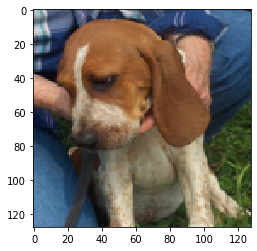

In [15]:
plt.imshow(X_train_hr[5])
plt.show()

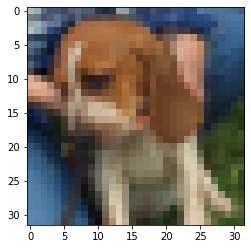

In [16]:
plt.imshow(X_train_lr[5])
plt.show()

In [17]:
def res_block(tensor, filters, kernel_size, stride=1):
  model = tensor
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same')(tensor)
  x = BatchNormalization(momentum=0.5)(x)
  x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
  x = BatchNormalization(momentum=0.5)(x)

  x = add([model,x])
  return x

In [18]:
def up_samplig_block(tensor,kernel_size, filters, strides):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(tensor)
  x = UpSampling2D(size=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x

In [19]:
def discriminator_block(tensor,filters, kernel_size, strides):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(tensor)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x


In [20]:
class Generator(object):

  def __init__(self, noise_shape):
    self.noise_shape = noise_shape

  def generator(self):

    g_input = Input(shape=self.noise_shape)
    x = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(g_input)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

    g_model = x
    
    # 16 bloques residual

    for index in range(8):
      print(index)
      x = res_block(x,filters=64, kernel_size = 3, stride=1)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.5)(x)
    
    x = add([g_model,x])

    # 2 upsamplin

    for index in range(2):
      x = up_samplig_block(x, kernel_size=3, filters=64, strides=1)


    x = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(x)
    x = Activation('tanh')(x)

    generator_model = Model(g_input, x)

    return generator_model
    

In [21]:

class Discriminator(object):

  def __init__(self, image_sahpe):
    self.image_shape = image_shape

  def discriminator(self):

    d_input = Input(shape=self.image_shape)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(d_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = discriminator_block(x, 64,3,2)
    x = discriminator_block(x, 128,3,1)
    x = discriminator_block(x, 128,3,2)
    x = discriminator_block(x, 256,3,1)
    x = discriminator_block(x, 256,3,2)
    x = discriminator_block(x, 512,3,1)
    x = discriminator_block(x, 512,3,2)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1)(x)
    x = Activation('sigmoid')(x)

    discriminator_model = Model(d_input, x)

    return discriminator_model


In [22]:
#optimizador usado VGG19
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
import keras.backend as K

class VGG_LOSS(object):

  def __init__(self, image_shape):
    self.image_shape = image_shape

  # funciones de perdida
  def vgg_loss(self, y_true, y_pred):

    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
      l.trainable = False

    x = Model(inputs=vgg19.input, outputs = vgg19.get_layer('block5_conv4').output)
    x.trainable = False

    return K.mean(K.square(x(y_true) - x(y_pred)))

def get_optimizer():

  adam = Adam(lr=1E-4, beta_1=0.9,beta_2=0.999, epsilon=1e-08)
  return adam


Using TensorFlow backend.


In [23]:
#Entrenamiento

from tqdm import tqdm
import numpy as np
import argparse
image_shape = X_train_hr[1,:,:].shape
downscale_factor=4

def get_gan_network(discriminator, shape,generator, optimizer, vgg_loss):
  discriminator.trainable = False
  gan_input = Input(shape=shape)
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs=gan_input, outputs=[x,gan_output])
  gan.compile(loss=[vgg_loss, "binary_crossentropy"], loss_weights=[1.,1e-3], optimizer=optimizer)
  return gan


def train(epochs, batch_size, X_train):
  loss = VGG_LOSS(image_shape)
  batch_count = int(X_train_hr.shape[0]/batch_size)
  shape = (image_shape[0]//downscale_factor,image_shape[1]//downscale_factor,image_shape[2])
  generator = Generator(shape).generator()
  discriminator = Discriminator(image_shape).discriminator()
  optimizer = get_optimizer()
  generator.compile(loss=loss.vgg_loss, optimizer=optimizer)
  discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
  gan = get_gan_network(discriminator, shape, generator, optimizer, loss.vgg_loss)
  loss_file = open('losses.txt','w+')
  loss_file.close()

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batch_count)):
      rand_nums = np.random.randint(0,X_train_hr.shape[0], size=batch_size)
      image_batch_hr = X_train_hr[rand_nums]
      image_batch_lr = X_train_lr[rand_nums]
      generate_images_sr = generator.predict(image_batch_lr)

      real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
      fake_data_Y = np.random.random_sample(batch_size)*0.2

      discriminator.trainable = True

      d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
      d_loss_fake = discriminator.train_on_batch(generate_images_sr, fake_data_Y)
      disciminator_loss = 0.5* np.add(d_loss_fake,d_loss_real)

      rand_nums = np.random.randint(0,X_train_hr.shape[0], size=batch_size)
      image_batch_hr = X_train_hr[rand_nums]
      image_batch_lr = X_train_lr[rand_nums]

      gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
      discriminator.trainable = False
      gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])

    print('discriminator_loss : %f' % discriminator_loss)

In [28]:
!nvidia-smi

Tue May 19 16:10:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   39C    P8     8W / 250W |    477MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   34C    P8     9W / 250W |    364MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [25]:
X_train_hr.shape[0]/800

1.0

In [27]:
train(100,800,X_train_hr)

0
1
2
3
4
5
6
7


  0%|          | 0/1 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


ValueError: in converted code:

    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_eager.py:305 train_on_batch  *
        outs, total_loss, output_losses, masks = (
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_eager.py:253 _process_single_batch
        training=training))
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_eager.py:167 _model_loss
        per_sample_losses = loss_fn.call(targets[i], outs[i])
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/losses.py:221 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    <ipython-input-22-87d9a729a880>:14 vgg_loss
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/applications/__init__.py:46 wrapper
        return base_fun(*args, **kwargs)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/applications/vgg19.py:32 VGG19
        return vgg19.VGG19(*args, **kwargs)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/keras_applications/vgg19.py:112 VGG19
        name='block1_conv1')(img_input)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:748 __call__
        self._maybe_build(inputs)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:2116 _maybe_build
        self.build(input_shapes)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/convolutional.py:158 build
        dtype=self.dtype)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:446 add_weight
        caching_device=caching_device)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:744 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py:142 make_variable
        shape=variable_shape if variable_shape else None)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:258 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:219 _variable_v1_call
        shape=shape)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:65 getter
        return captured_getter(captured_previous, **kwargs)
    /home/cdayan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/def_function.py:502 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.
